# CNN Classifier

the baseline implementation of CNN

In [ ]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [ ]:
# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self, num_classes=15, weight_std=0.01):
        super(CNN, self).__init__()          # Initialize parent nn.Module class
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(                   # Define a 2D convolution layer
            1,                                    # Input channels (grayscale images)
            8,                                    # Output channels / feature maps
            kernel_size=3,                        # 3×3 convolutional kernel
            stride=1,                             # Step size of kernel
            padding=1                             # Keep spatial resolution (same padding)
        )
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(
            8,                                    # Input channels from previous layer
            16,                                   # Output channels
            kernel_size=3,
            stride=1,
            padding=1
        )

        # Third convolutional layer
        self.conv3 = nn.Conv2d(
            16,
            32,
            kernel_size=3,
            stride=1,
            padding=1
        )

        # Max pooling layer (downsamples spatial resolution by 2×)
        self.pool = nn.MaxPool2d(
            kernel_size=2,                        # Pool over 2×2 spatial regions
            stride=2                              # Move by 2 pixels > halves width & height
        )

        # Activation function (non-linearity)
        self.relu = nn.ReLU(inplace=True)          # ReLU applied in-place to save memory

        # Fully connected (dense) classifier layer
        self.fc = nn.Linear(
            32 * 16 * 16,                         # Flattened feature size
            num_classes                           # Final output logits (# of classes)
        )

    def forward(self, x):
        x = self.relu(self.conv1(x))              # Apply conv1 + ReLU
        x = self.pool(x)                          # Downsample to 32×32
        
        x = self.relu(self.conv2(x))              # Apply conv2 + ReLU
        x = self.pool(x)                          # Downsample to 16×16
        
        x = self.relu(self.conv3(x))              # Apply conv3 + ReLU
        
        x = x.view(x.size(0), -1)                 # Flatten batch of feature maps
        
        x = self.fc(x)                            # Linear classification layer
        return x                                  # Return logits


# Training helper
def train_one_epoch(model, loader, criterion, optimizer, device):

    model.train()                                   # Set model to training mode

    total_loss = 0.0                                # Track accumulated loss
    correct = 0                                     # Count correct predictions
    total = 0                                       # Count total samples
    
    for inputs, targets in loader:                  # Loop over batches in dataloader
    
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to GPU/CPU
    
        optimizer.zero_grad()                       # Reset gradients from previous batch
    
        outputs = model(inputs)                     # Forward pass: compute predictions
    
        loss = criterion(outputs, targets)          # Compute training loss (CrossEntropy)
    
        loss.backward()                             # Backpropagate gradients
    
        optimizer.step()                            # Update model parameters

        total_loss += loss.item() * inputs.size(0)  # Add batch loss to total loss
        
        _, preds = outputs.max(1)                   # Predicted class = index with max logit
        
        correct += preds.eq(targets).sum().item()   # Count correct predictions in batch
        
        total += targets.size(0)                    # Increase total sample counter
    
    return total_loss / total, correct / total      # Return avg loss and accuracy for epoch

# Evaluation 
def evaluate(model, loader, criterion, device):

    model.eval()                                   # Set model to evaluation mode
    
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():                          # No gradient computation (faster, memory-saving)
    
        for inputs, targets in loader:
    
            inputs, targets = inputs.to(device), targets.to(device)  # Move to GPU/CPU
            
            outputs = model(inputs)                 # Forward pass only
            
            loss = criterion(outputs, targets)      # Compute validation/test loss
            
            total_loss += loss.item() * inputs.size(0)  # Accumulate loss
            
            _, preds = outputs.max(1)               # Get predicted class
            
            correct += preds.eq(targets).sum().item()  # Count correct predictions
            
            total += targets.size(0)                    # Count samples
            
    return total_loss / total, correct / total      # Return avg loss and accuracy


In [4]:
# Set the path to your dataset and parameters
data_root = Path('/Users/leonardoangellotti/Desktop/universita/Comp_Vision/CNN/original_data')
batch_size = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Define class names
class_names = ['Bedroom', 'Coast', 'Forest', 'Highway', 'Industrial', 'InsideCity',
               'Kitchen', 'LivingRoom', 'Mountain', 'Office', 'OpenCountry',
               'Store', 'Street', 'Suburb', 'TallBuilding']

# Data transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5], std=[0.5]),
])

# Load datasets
train_dir = data_root / 'train'
val_dir = data_root / 'val'
test_dir = data_root / 'test'

train_dataset = datasets.ImageFolder(str(train_dir), transform=transform)

if val_dir.exists():
    val_dataset = datasets.ImageFolder(str(val_dir), transform=transform)
else:
    total_train = len(train_dataset)
    val_size = int(0.15 * total_train)
    train_size = total_train - val_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size],
                                            generator=torch.Generator().manual_seed(42))

test_dataset = datasets.ImageFolder(str(test_dir), transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

Using device: cpu


In [5]:
# Number of training samples
print("Number of training images:", len(train_dataset))

# Inspect one batch
images, labels = next(iter(train_loader))
print("Batch image tensor shape:", images.shape)
print("Batch label tensor shape:", labels.shape)

# Inspect one image
print("Single image shape:", images[0].shape)


Number of training images: 1275
Batch image tensor shape: torch.Size([32, 1, 64, 64])
Batch label tensor shape: torch.Size([32])
Single image shape: torch.Size([1, 64, 64])


In [ ]:
from torchvision.transforms import ToPILImage

def plot_sample_images_per_class_2rows(train_loader, class_names):

    num_classes = len(class_names)
    sample_images = [None] * num_classes

    # Collect one sample per class
    for images, labels in train_loader:
        images = images.cpu()
        labels = labels.cpu()

        for img, lab in zip(images, labels):
            lab = int(lab.item())
            if sample_images[lab] is None:
                sample_images[lab] = img

        if all(img is not None for img in sample_images):
            break

    # Layout: two rows > first row 8 images, second row 7 images
    rows = 2
    cols_row1 = 8
    cols_row2 = num_classes - cols_row1  # = 7

    fig, axes = plt.subplots(rows, cols_row1, figsize=(cols_row1 * 2, 4))

    # Flatten axes for easier indexing, but note last row only uses 7 columns
    axes = axes.reshape(rows, cols_row1)

    # Plot first row (0–7)
    for i in range(cols_row1):
        img = ToPILImage()(sample_images[i].squeeze(0))
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(class_names[i], fontsize=8)
        axes[0, i].axis('off')

    # Plot second row (8–14)
    for j in range(cols_row2):
        img = ToPILImage()(sample_images[cols_row1 + j].squeeze(0))
        axes[1, j].imshow(img, cmap='gray')
        axes[1, j].set_title(class_names[cols_row1 + j], fontsize=8)
        axes[1, j].axis('off')

    # Hide unused axes (only needed for last column of row 2)
    for k in range(cols_row2, cols_row1):
        axes[1, k].axis('off')

    plt.tight_layout()
    plt.show()


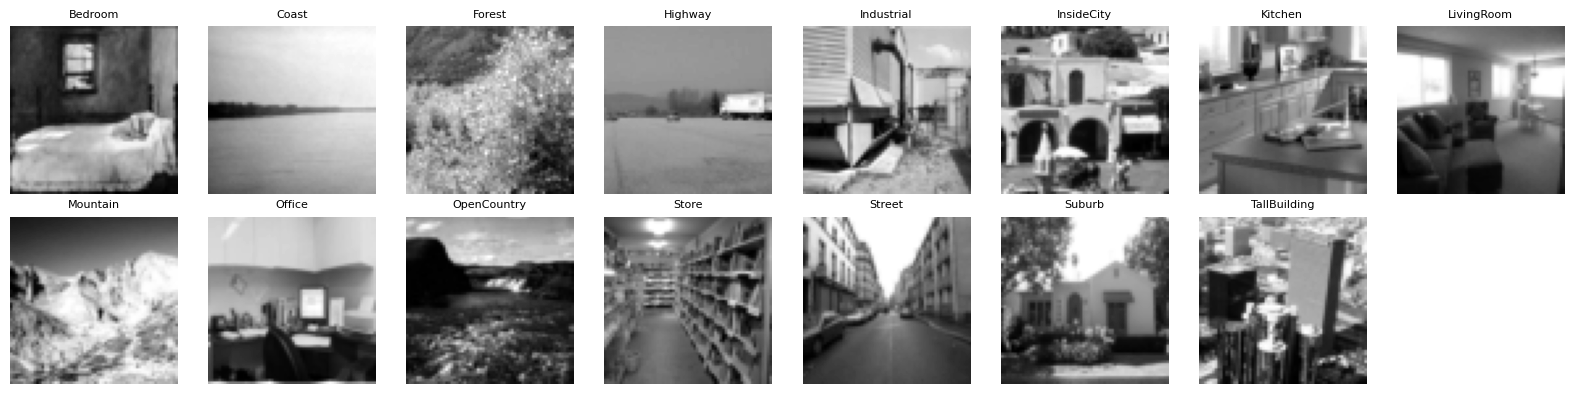

In [7]:
plot_sample_images_per_class_2rows(train_loader, class_names)

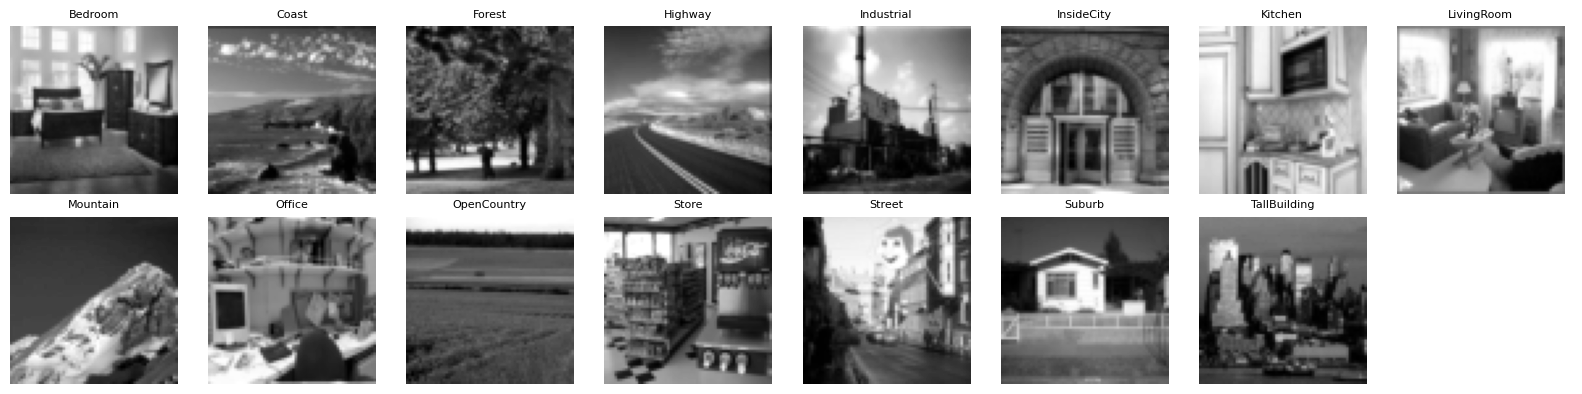

In [8]:
plot_sample_images_per_class_2rows(val_loader, class_names)

In [9]:
num_epochs = 12
learning_rate = 0.01
momentum = 0.9

Epoch 1/12 - train_loss: 2.7121, train_acc: 0.0659, val_loss: 2.7064, val_acc: 0.0711
Epoch 2/12 - train_loss: 2.7052, train_acc: 0.0839, val_loss: 2.6969, val_acc: 0.1156
Epoch 3/12 - train_loss: 2.6643, train_acc: 0.1349, val_loss: 2.5778, val_acc: 0.1556
Epoch 4/12 - train_loss: 2.5015, train_acc: 0.1914, val_loss: 2.4841, val_acc: 0.2044
Epoch 5/12 - train_loss: 2.4152, train_acc: 0.2290, val_loss: 2.3986, val_acc: 0.2311
Epoch 6/12 - train_loss: 2.3489, train_acc: 0.2557, val_loss: 2.5177, val_acc: 0.2444
Epoch 7/12 - train_loss: 2.2727, train_acc: 0.2863, val_loss: 2.4085, val_acc: 0.2489
Epoch 8/12 - train_loss: 2.0650, train_acc: 0.3443, val_loss: 2.2664, val_acc: 0.2889
Epoch 9/12 - train_loss: 1.8838, train_acc: 0.4141, val_loss: 2.2396, val_acc: 0.3289
Epoch 10/12 - train_loss: 1.6496, train_acc: 0.4824, val_loss: 2.1904, val_acc: 0.3289
Epoch 11/12 - train_loss: 1.4288, train_acc: 0.5498, val_loss: 2.4428, val_acc: 0.3244
Epoch 12/12 - train_loss: 1.1318, train_acc: 0.6369,

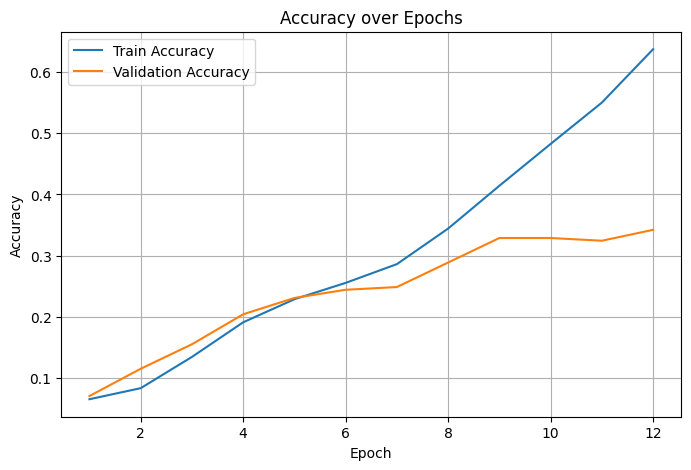

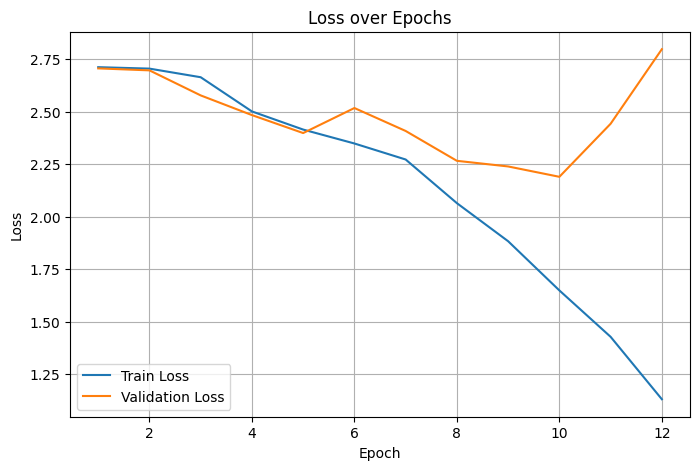

In [ ]:
# Create model, criterion, optimizer
model = CNN(num_classes=len(class_names)).to(device)  

criterion = nn.CrossEntropyLoss()  
# Loss function for multi-class classification (softmax + NLL internally)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)  
# Stochastic Gradient Descent optimizer with momentum


# Training loop with early stopping
train_losses, val_losses = [], []   # Track training and validation loss over epochs
train_accs, val_accs = [] , []      # Track training and validation accuracy

best_val_loss = float('inf')        # Initialize best validation loss for early stopping
patience, patience_counter = 10, 0  # Stop training if no improvement after 'patience' epochs


for epoch in range(1, num_epochs + 1):   # Loop over all epochs

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    # Train for one full pass over training dataset → return avg loss + accuracy

    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    # Evaluate on validation dataset (no gradient updates)

    # Save metrics for plots
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # Print progress output
    print(f'Epoch {epoch}/{num_epochs} - train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, '
          f'val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}')


    # ---------- EARLY STOPPING BLOCK ----------
    if val_loss < best_val_loss:
        best_val_loss = val_loss       # Update best validation loss
        patience_counter = 0           # Reset counter because model improved
        torch.save(model.state_dict(), 'best_model.pth')
        # Save model weights when improvement is observed

    else:
        patience_counter += 1          # Increase counter because no improvement

        if patience_counter >= patience:  
            # Stop training if model has not improved for 'patience' epochs
            print('Early stopping triggered.')
            break
    # -------------------------------------------


# Load best model and plot training curves
model.load_state_dict(torch.load('best_model.pth', map_location=device))
# Load the best-performing checkpoint (based on validation loss)


# Build epoch index for plots
epochs_range = range(1, len(train_losses) + 1)

# -------- ACCURACY PLOT --------
plt.figure(figsize=(8, 5))                              # Create a new plot
plt.plot(epochs_range, train_accs, label='Train Accuracy')   # Train accuracy curve
plt.plot(epochs_range, val_accs, label='Validation Accuracy') # Validation accuracy curve
plt.xlabel('Epoch')                                     # X-axis label
plt.ylabel('Accuracy')                                  # Y-axis label
plt.title('Accuracy over Epochs')                       # Plot title
plt.legend()                                            # Plot legend
plt.grid(True)                                          # Add grid
plt.show()                                              # Display the plot


# -------- LOSS PLOT --------
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_losses, label='Train Loss')      # Train loss curve
plt.plot(epochs_range, val_losses, label='Validation Loss')   # Validation loss curve
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


Test Accuracy: 29.38%


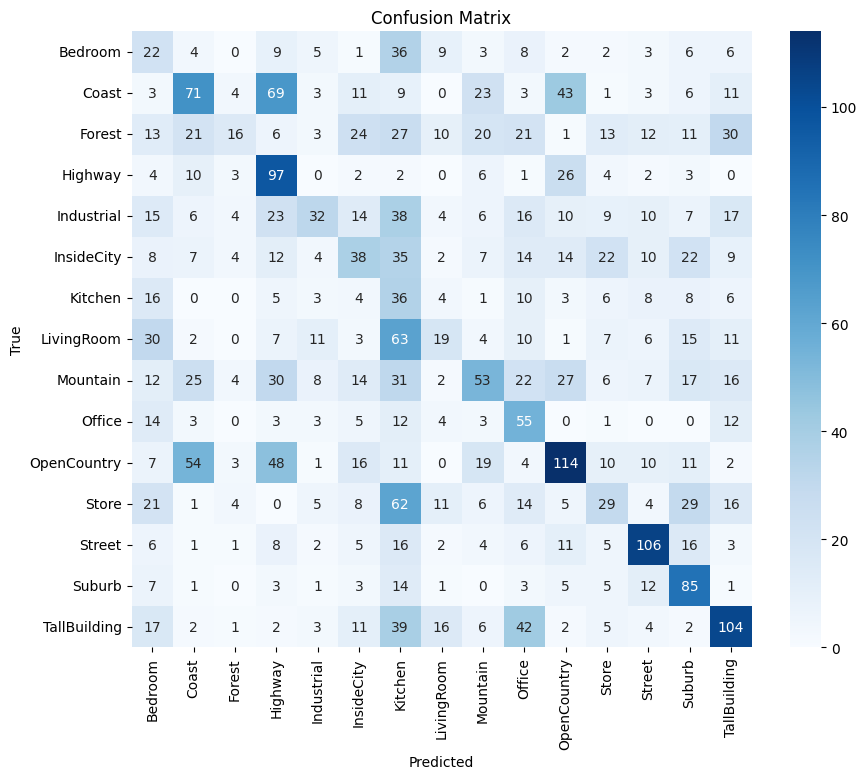

In [11]:
# Evaluate on the test set and display confusion matrix
model.eval()
all_preds, all_targets = [], []

with torch.no_grad():

    for inputs, targets in test_loader:

        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

test_acc = np.mean(np.array(all_preds) == np.array(all_targets))
print(f'Test Accuracy: {test_acc * 100:.2f}%')

cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix'); plt.show()